## Question 2:
> Adaboost

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
from util_functions import Point, create_data_from_file, split_data

### Utils for the AdaBoost classifier:

In [2]:
def predict(rules: list, point: Point):
    sums = 0
    for h in rules:
        sums += h.w * h.eval(point)
    return 1 if sums > 0 else -1


def point_error(rules: list, point: Point):
    """
    This function calculates the error on given point with a given set of rules
    """
    return 1 if predict(rules, point) != point.label else 0


def list_error(rules: list, points: list):
    """
      This function calculates the error on given points
      """
    total_error = 0
    for p in points:
        error = point_error(rules, p)
        total_error += error

    return total_error / len(points)


def calculate_error(rules: list, train: list, test: list, iterations: int):
    """
    This function calculates the empirical error on the training and test sets.
    """
    tr_errors = []
    te_errors = []
    iterations = len(rules) if iterations > len(rules) else iterations
    for i in range(iterations):
        tr_errors.append(list_error(rules[:i + 1], train))
        te_errors.append(list_error(rules[:i + 1], test))
    return tr_errors, te_errors

In [3]:
def run(points: list, rules: list, iterations: int):
    """
    This function executer a single run of adaboost algorithm.
    :param points: list of data points objects
    :param iterations: number of iterations to perform the algorithm.
    :return:
    """
    train, test = split_data(points)
    for pt in train:
        pt.w = 1 / len(train)  # initialize point weights
    min_lines = []
    for i in range(iterations):
        min_error = np.inf  # Find the min error each iteration and the classifier.
        min_clfs = []
        for h in rules:
            error = 0
            for pt in train:
                # caculate weighted error
                if h.eval(pt) != pt.label:
                    error += pt.w

            if len(min_clfs) == 0 or error <= min_error:  # find min of error classifier
                if error != min_error:  # if its smaller than the current min classifier then change it
                    min_error = error
                    min_clfs.clear()
                min_clfs.append(h)
        clf_weight = 0.5 * np.log((1 - min_error) / min_error)  # update classifier weight based on error
        Zt = 0
        min_clf = random.choice(min_clfs) # get the best classifier (minimum)
        for pt in train:
            # Calculate the normalizing constant (Zt) step 5.5 and update all the points weights
            pt.w = pt.w / (np.e ** (clf_weight * min_clf.eval(pt) * pt.label))
            Zt += pt.w
        for pt in train:
            pt.w = pt.w / Zt
        min_clf.w = clf_weight
        min_lines.append(min_clf)
    return calculate_error(min_lines, train, test, iterations)

In [4]:
dots, lines = create_data_from_file('four_circle.txt', get_rules=True)
iterations = 8
rounds = 100
error_means_train = []
error_means_test = []
train_errors= np.zeros(shape=(rounds,iterations))
test_errors = np.zeros(shape=(rounds,iterations))

for a in range(rounds):
    train_error, test_error = run(dots, lines, iterations)
    error_means_train.append(np.mean(train_error))
    error_means_test.append(np.mean(test_error))
    
    for b in range(iterations):
        train_errors[a][b] = train_error[b]
        test_errors[a][b] = test_error[b]

error
k = 1 train error:  0.220 test error:  0.267
k = 2 train error:  0.265 test error:  0.251
k = 3 train error:  0.000 test error:  0.024
k = 4 train error:  0.012 test error:  0.041
k = 5 train error:  0.000 test error:  0.021
k = 6 train error:  0.000 test error:  0.021
k = 7 train error:  0.000 test error:  0.021
k = 8 train error:  0.000 test error:  0.020


In [5]:
print("Error")
i_train_error_graph = []
i_test_error_graph = []
for c in range(iterations):
    i_train_error = np.mean(train_errors[:,c])
    i_train_error_graph.append(i_train_error)
    i_test_error = np.mean(test_errors[:,c])
    i_test_error_graph.append(i_test_error)
    print(f"k = {c + 1}",
          "train error: ", "%.3f" % i_train_error,
          "| test error: ", "%.3f" % i_test_error)
    

k = 1 train error:  0.220 | test error:  0.267
k = 2 train error:  0.265 | test error:  0.251
k = 3 train error:  0.000 | test error:  0.024
k = 4 train error:  0.012 | test error:  0.041
k = 5 train error:  0.000 | test error:  0.021
k = 6 train error:  0.000 | test error:  0.021
k = 7 train error:  0.000 | test error:  0.021
k = 8 train error:  0.000 | test error:  0.020


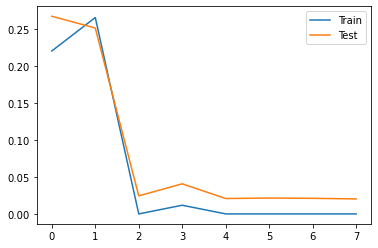

In [6]:
plt.plot(i_train_error_graph, label='Train')
plt.plot(i_test_error_graph, label="Test")
plt.legend()
plt.show()

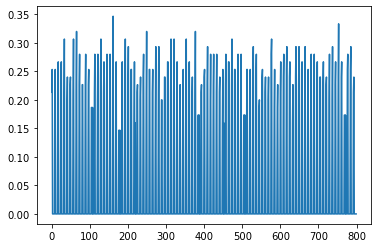

In [8]:
plt.plot(train_errors.flatten())
plt.show()

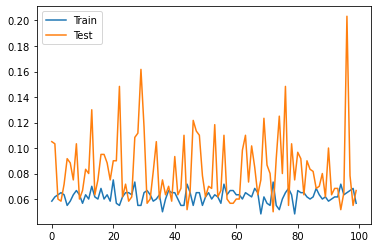

In [9]:
plt.plot(error_means_train, label='Train')
plt.plot(error_means_test, label='Test')
plt.legend(loc="upper left")
plt.show()


In [10]:
def most_important(lines):
    min_l=lines[0]
    imp=[]
    for j in range(iterations):
        min_lw=-np.inf
        for i in range(len(lines)):
            if lines[i].w<min_lw:
                min_l=lines[i]
                min_lw=lines[i].w
        imp.append(min_l)
        lines.delete(min_l)
    return imp